In [1]:
import os
import pandas as pd
from tabulate import tabulate
from dotenv import load_dotenv
import snowflake.connector
import sys

load_dotenv()

# --- Your provided Snowflake connection details ---
# This connection is for *reading* from INCREMENTALITY.
# We no longer need to switch contexts, as we are not creating objects.
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE', 'COMPUTE_WH'),
    database='INCREMENTALITY', # Source database for Clicks and Purchases
    schema='INCREMENTALITY_RESEARCH' # Schema for Clicks and Purchases
)
cursor = conn.cursor()

def run_query(query):
    try:
        cursor.execute(query)
        # For SELECT queries, fetch results
        if cursor.description:
            results = cursor.fetchall()
            columns = [desc[0] for desc in cursor.description]
            return pd.DataFrame(results, columns=columns)
        # For DDL/DML, no results to fetch (though we won't be doing DDL now)
        return pd.DataFrame()
    except snowflake.connector.ProgrammingError as e:
        print(f"\nERROR executing query:\n{query}\nDetails: {e}")
        raise # Re-raise the exception to stop execution on error

def show_table(df, title=""):
    if title:
        print(f"\n{title}")
        print("="*len(title))
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

print("✅ Connected to Snowflake")

# Define the pilot week for consistency
PILOT_WEEK_START = '2025-07-01 00:00:00'
PILOT_WEEK_END = '2025-07-08 00:00:00' # End is exclusive

print("\n--- Generating User-Vendor-Week Panel for Pilot Week ---")
print(f"   Using data from {PILOT_WEEK_START} to {PILOT_WEEK_END} (exclusive)")

✅ Connected to Snowflake

--- Generating User-Vendor-Week Panel for Pilot Week ---
   Using data from 2025-07-01 00:00:00 to 2025-07-08 00:00:00 (exclusive)


In [2]:
# --- Configuration for Full-History Panel ---
print(f"--- Generating Full-History Clicks-Only Vendor Panel ---")
print("   Based on the date check, this will process data from roughly 2025-03-14 to 2025-09-07.")

# --- Define the Full-History Vendor-Week Panel Aggregation Query ---
# This query processes all available data by removing the WHERE date clauses.
vendor_panel_query_full_history = """
WITH
-- Step 1: Aggregate all historical clicks per vendor *per week*.
CLICKS_WEEKLY AS (
    SELECT
        VENDOR_ID,
        DATE_TRUNC('WEEK', OCCURRED_AT) AS week,
        COUNT(DISTINCT INTERACTION_ID) AS click_count
    FROM CLICKS
    GROUP BY VENDOR_ID, week
),

-- Step 2: Create a CLICK-BASED map from all historical data.
PRODUCT_VENDOR_MAP_CLICKS AS (
    SELECT DISTINCT PRODUCT_ID, VENDOR_ID
    FROM CLICKS
    WHERE VENDOR_ID IS NOT NULL AND PRODUCT_ID IS NOT NULL
),

-- Step 3: Aggregate all historical attributed purchases and revenue per vendor *per week*.
PURCHASES_WEEKLY AS (
    SELECT
        pvm.VENDOR_ID,
        DATE_TRUNC('WEEK', p.PURCHASED_AT) AS week,
        COUNT(DISTINCT p.PURCHASE_ID) AS purchase_count,
        COALESCE(SUM(p.QUANTITY * p.UNIT_PRICE), 0) AS total_revenue_cents
    FROM PURCHASES AS p
    JOIN PRODUCT_VENDOR_MAP_CLICKS AS pvm ON p.PRODUCT_ID = pvm.PRODUCT_ID
    GROUP BY pvm.VENDOR_ID, week
)

-- Final Step: Join all weekly aggregates into the final panel.
SELECT
    c.week,
    c.vendor_id,
    c.click_count AS clicks,
    COALESCE(p.purchase_count, 0) AS purchases,
    (COALESCE(p.total_revenue_cents, 0) / 100)::DECIMAL(18, 2) AS revenue_dollars
    
FROM CLICKS_WEEKLY AS c
LEFT JOIN PURCHASES_WEEKLY AS p ON c.vendor_id = p.vendor_id AND c.week = p.week
ORDER BY c.vendor_id, c.week;
"""

try:
    # Execute the query to build the full panel
    vendor_panel_full_df = run_query(vendor_panel_query_full_history)
    print(f"\n✅ Successfully generated full-history panel with {len(vendor_panel_full_df):,} rows.")

    # Process and save the DataFrame
    vendor_panel_full_df.columns = [col.lower() for col in vendor_panel_full_df.columns]
    
    # Save to a new Parquet file
    output_filename = "vendor_panel_full_history_clicks_only.parquet"
    vendor_panel_full_df.to_parquet(output_filename, index=False, engine='pyarrow')
    
    print(f"\n✅ Data successfully processed and saved to '{output_filename}'")
    show_table(vendor_panel_full_df.head(10), f"Data Sample from '{output_filename}'")

except Exception as e:
    print(f"\nAn error occurred during panel generation: {e}")

--- Generating Full-History Clicks-Only Vendor Panel ---
   Based on the date check, this will process data from roughly 2025-03-14 to 2025-09-07.

✅ Successfully generated full-history panel with 1,019,609 rows.

✅ Data successfully processed and saved to 'vendor_panel_full_history_clicks_only.parquet'

Data Sample from 'vendor_panel_full_history_clicks_only.parquet'
+---------------------+--------------------------------------+----------+-------------+-------------------+
| week                | vendor_id                            |   clicks |   purchases |   revenue_dollars |
+=====================+======================================+==========+=============+===================+
| 2025-03-10 00:00:00 | 018e6680-782e-7124-b66d-5511af1480b4 |       38 |           0 |                 0 |
+---------------------+--------------------------------------+----------+-------------+-------------------+
| 2025-03-17 00:00:00 | 018e6680-782e-7124-b66d-5511af1480b4 |        1 |           0 |  

# eda

In [66]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# --- Prerequisite: Load and Prepare Data ---
# This block loads the data once and prepares it for all subsequent EDA steps.
try:
    if 'df_analysis' not in locals() or 'log_clicks_plus_1' not in df_analysis.columns:
        parquet_filename = 'vendor_panel_full_history_clicks_only.parquet'
        print(f"--- Loading and preparing data from '{parquet_filename}' ---")
        df_analysis = pd.read_parquet(parquet_filename)

        # Convert types for calculations and modeling
        df_analysis['revenue_dollars'] = df_analysis['revenue_dollars'].astype(float)
        df_analysis['clicks'] = df_analysis['clicks'].astype(int)
        df_analysis['purchases'] = df_analysis['purchases'].astype(int)
        df_analysis['week'] = pd.to_datetime(df_analysis['week'])
        
        # Create log-transformed variables for analysis
        df_analysis['log_revenue_plus_1'] = np.log1p(df_analysis['revenue_dollars'])
        df_analysis['log_clicks_plus_1'] = np.log1p(df_analysis['clicks'])
        print(f"✅ Data loaded and prepared successfully.\n")

except FileNotFoundError:
    print(f"ERROR: The file 'vendor_panel_full_history_clicks_only.parquet' was not found.")
    df_analysis = pd.DataFrame()

# --- Main EDA Block ---
# All analysis is contained within this block to ensure it only runs if data loading was successful.
if not df_analysis.empty:

    # EDA 1: High-Level Overview
    display(Markdown("### EDA 1: High-Level Overview"))
    num_rows, num_cols = df_analysis.shape
    num_vendors = df_analysis['vendor_id'].nunique()
    num_weeks = df_analysis['week'].nunique()
    summary_data = {
        "Metric": ["Total Observations (Rows)", "Total Columns", "Unique Vendors", "Unique Weeks"],
        "Value": [f"{num_rows:,}", num_cols, f"{num_vendors:,}", num_weeks]
    }
    show_table(pd.DataFrame(summary_data), "Dataset Dimensions")
    show_table(df_analysis.dtypes.to_frame('data_type').reset_index(), "Column Data Types")

    # EDA 2: Panel Structure Analysis
    display(Markdown("### EDA 2: Panel Structure Analysis"))
    vendor_week_counts = df_analysis['vendor_id'].value_counts()
    panel_structure = vendor_week_counts.value_counts().sort_index(ascending=False).to_frame('number_of_vendors')
    panel_structure.index.name = 'weeks_of_data_per_vendor'
    show_table(panel_structure.reset_index(), "Distribution of Observations per Vendor")
    print("\nInterpretation: This table shows how many vendors have data for a specific number of weeks.")
    print("A large number of vendors with few weeks of data can make estimating individual effects noisy.")

    # EDA 3: Distribution of Core Metrics
    display(Markdown("### EDA 3: Distribution of Core Metrics"))
    show_table(df_analysis[['clicks', 'purchases', 'revenue_dollars']].describe().reset_index(), 
               "Overall Distribution of Key Metrics")
    zero_revenue_pct = (df_analysis['revenue_dollars'] == 0).mean() * 100
    print(f"\nZero-Revenue Observations: {zero_revenue_pct:.2f}% of the panel has zero weekly revenue.")
    df_positive_revenue = df_analysis[df_analysis['revenue_dollars'] > 0]
    show_table(df_positive_revenue[['clicks', 'purchases', 'revenue_dollars']].describe().reset_index(),
               "Distribution for Positive-Revenue Weeks ONLY")

    # EDA 4: Platform-Wide Weekly Trends
    display(Markdown("### EDA 4: Platform-Wide Weekly Trends"))
    weekly_summary = df_analysis.groupby('week').agg(
        total_revenue=('revenue_dollars', 'sum'),
        total_clicks=('clicks', 'sum'),
        active_vendors=('vendor_id', 'nunique')
    ).reset_index()
    weekly_summary['total_revenue'] = weekly_summary['total_revenue'].apply(lambda x: f"${x:,.0f}")
    weekly_summary['total_clicks'] = weekly_summary['total_clicks'].apply(lambda x: f"{x:,}")
    weekly_summary['active_vendors'] = weekly_summary['active_vendors'].apply(lambda x: f"{x:,}")
    show_table(weekly_summary.sort_values('week', ascending=False), "Weekly Platform Aggregates")
    print("\nInterpretation: Look for trends, seasonality, or sudden spikes/dips in platform activity.")

    # EDA 5: Correlation Analysis
    display(Markdown("### EDA 5: Correlation Analysis"))
    corr_raw = df_analysis[['clicks', 'purchases', 'revenue_dollars']].corr()
    show_table(corr_raw.reset_index(), "Correlation Matrix (Raw Values)")
    corr_log = df_analysis[['log_clicks_plus_1', 'log_revenue_plus_1']].corr()
    show_table(corr_log.reset_index(), "Correlation Matrix (Log-Transformed Values)")
    print("\nInterpretation: The log-transformed correlation is a better preview of the linear relationship your model will estimate.")

    # EDA 6: Top Vendor Summary
    display(Markdown("### EDA 6: Top Vendor Analysis"))
    vendor_summary = df_analysis.groupby('vendor_id').agg(
        total_revenue=('revenue_dollars', 'sum'),
        total_clicks=('clicks', 'sum'),
        weeks_active=('week', 'count')
    ).nlargest(15, 'total_revenue').reset_index()
    vendor_summary['total_revenue'] = vendor_summary['total_revenue'].apply(lambda x: f"${x:,.0f}")
    vendor_summary['total_clicks'] = vendor_summary['total_clicks'].apply(lambda x: f"{x:,}")
    show_table(vendor_summary, "Top 15 Vendors by Total Revenue")
    print("\nInterpretation: This shows if revenue is heavily concentrated among a few top vendors.")

else:
    print("Could not perform EDA because the DataFrame is empty.")

### EDA 1: High-Level Overview


Dataset Dimensions
+---------------------------+---------+
| Metric                    | Value   |
+===========================+=========+
| Total Observations (Rows) | 979,290 |
+---------------------------+---------+
| Total Columns             | 7       |
+---------------------------+---------+
| Unique Vendors            | 150,075 |
+---------------------------+---------+
| Unique Weeks              | 26      |
+---------------------------+---------+

Column Data Types
+--------------------+----------------+
| index              | data_type      |
+====================+================+
| week               | datetime64[ns] |
+--------------------+----------------+
| vendor_id          | object         |
+--------------------+----------------+
| clicks             | int64          |
+--------------------+----------------+
| purchases          | int64          |
+--------------------+----------------+
| revenue_dollars    | float64        |
+--------------------+----------------+
|

### EDA 2: Panel Structure Analysis


Distribution of Observations per Vendor
+----------------------------+---------------------+
|   weeks_of_data_per_vendor |   number_of_vendors |
+============================+=====================+
|                         26 |                7046 |
+----------------------------+---------------------+
|                         25 |                1921 |
+----------------------------+---------------------+
|                         24 |                1383 |
+----------------------------+---------------------+
|                         23 |                1243 |
+----------------------------+---------------------+
|                         22 |                1198 |
+----------------------------+---------------------+
|                         21 |                1227 |
+----------------------------+---------------------+
|                         20 |                1218 |
+----------------------------+---------------------+
|                         19 |                1210 |
+----

### EDA 3: Distribution of Core Metrics


Overall Distribution of Key Metrics
+---------+------------+--------------+-------------------+
| index   |     clicks |    purchases |   revenue_dollars |
+=========+============+==============+===================+
| count   | 979290     | 979290       |       979290      |
+---------+------------+--------------+-------------------+
| mean    |    148.782 |      2.10557 |           88.0226 |
+---------+------------+--------------+-------------------+
| std     |    211.418 |      6.13956 |          380.854  |
+---------+------------+--------------+-------------------+
| min     |      1     |      0       |            0      |
+---------+------------+--------------+-------------------+
| 25%     |     56     |      0       |            0      |
+---------+------------+--------------+-------------------+
| 50%     |    102     |      1       |           18      |
+---------+------------+--------------+-------------------+
| 75%     |    168     |      2       |           76      |
+--

### EDA 4: Platform-Wide Weekly Trends


Weekly Platform Aggregates
+---------------------+-----------------+----------------+------------------+
| week                | total_revenue   | total_clicks   | active_vendors   |
+=====================+=================+================+==================+
| 2025-09-01 00:00:00 | $3,582,007      | 6,520,078      | 42,487           |
+---------------------+-----------------+----------------+------------------+
| 2025-08-25 00:00:00 | $3,999,679      | 7,094,910      | 41,577           |
+---------------------+-----------------+----------------+------------------+
| 2025-08-18 00:00:00 | $4,056,596      | 7,049,578      | 41,499           |
+---------------------+-----------------+----------------+------------------+
| 2025-08-11 00:00:00 | $4,022,353      | 7,119,281      | 42,442           |
+---------------------+-----------------+----------------+------------------+
| 2025-08-04 00:00:00 | $4,031,077      | 6,970,287      | 43,641           |
+---------------------+-------------

### EDA 5: Correlation Analysis


Correlation Matrix (Raw Values)
+-----------------+----------+-------------+-------------------+
| index           |   clicks |   purchases |   revenue_dollars |
+=================+==========+=============+===================+
| clicks          | 1        |    0.546619 |          0.383178 |
+-----------------+----------+-------------+-------------------+
| purchases       | 0.546619 |    1        |          0.642807 |
+-----------------+----------+-------------+-------------------+
| revenue_dollars | 0.383178 |    0.642807 |          1        |
+-----------------+----------+-------------+-------------------+

Correlation Matrix (Log-Transformed Values)
+--------------------+---------------------+----------------------+
| index              |   log_clicks_plus_1 |   log_revenue_plus_1 |
+====================+=====================+======================+
| log_clicks_plus_1  |            1        |             0.493968 |
+--------------------+---------------------+---------------------

### EDA 6: Top Vendor Analysis


Top 15 Vendors by Total Revenue
+--------------------------------------+-----------------+----------------+----------------+
| vendor_id                            | total_revenue   | total_clicks   |   weeks_active |
+======================================+=================+================+================+
| 01952a60-9005-73b0-98b8-3b3a6a25fd6c | $720,673        | 8,492          |             26 |
+--------------------------------------+-----------------+----------------+----------------+
| 065298be-a5e6-7435-ad24-36ff8f3c7c7c | $471,834        | 16,471         |             26 |
+--------------------------------------+-----------------+----------------+----------------+
| 064df69b-496a-78d6-b124-3c6c0c2a0b90 | $288,457        | 122,298        |             17 |
+--------------------------------------+-----------------+----------------+----------------+
| 064ce6ab-dd22-7987-a124-0b003531c280 | $252,327        | 25,906         |             26 |
+------------------------------------

# avg effect of clicks on revenue

In [52]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, Markdown

# --- 1. Set up rpy2 Environment for fixest ---
# (Assuming setup is complete and successful)
if not rpy2_setup_failed:
    # --- 2. Load and Prepare the Full-History Panel Data ---
    parquet_filename = 'vendor_panel_full_history_clicks_only.parquet'
    try:
        display(Markdown("### 1. Data Loading and Validation (Full History Panel)"))
        print(f"\n--- Loading panel data from '{parquet_filename}' ---")
        df_analysis = pd.read_parquet(parquet_filename)
        
        # =======================================================================
        # THE FIX: Convert Decimal and other numeric types to standard floats/integers
        # that NumPy and R can work with seamlessly.
        # =======================================================================
        df_analysis['revenue_dollars'] = df_analysis['revenue_dollars'].astype(float)
        df_analysis['clicks'] = df_analysis['clicks'].astype(int)
        df_analysis['purchases'] = df_analysis['purchases'].astype(int)
        
        # Prepare log-transformed variables
        df_analysis['log_revenue_plus_1'] = np.log1p(df_analysis['revenue_dollars'])
        df_analysis['log_clicks_plus_1'] = np.log1p(df_analysis['clicks'])
        
        print(f"✅ Loaded, converted, and prepared panel with {len(df_analysis):,} rows.")

    except Exception as e:
        print(f"ERROR during data loading: {e}")
        df_analysis = pd.DataFrame()

    if not df_analysis.empty:
        # --- 3. Run the Main Fixed-Effects Model ---
        try:
            display(Markdown("---"))
            display(Markdown("### 2. Main Model: Two-Way Fixed Effects (Log-Log)"))
            display(Markdown("This model estimates the *average* elasticity across all vendors on the full historical dataset."))
            
            with localconverter(ro.default_converter + pandas2ri.converter):
                ro.globalenv['df_for_r_full'] = pandas2ri.py2rpy(df_analysis)

            print("\nEstimating Average Effect: log(revenue+1) ~ log(clicks+1) | vendor_id + week")
            ro.r("""
            library(fixest)
            df_panel_full <- df_for_r_full
            
            model_main <- feols(log_revenue_plus_1 ~ log_clicks_plus_1 | vendor_id + week, 
                                data = df_panel_full, 
                                vcov = ~vendor_id)
            
            print(etable(model_main, digits = 4))
            """)
            
            display(Markdown("✅ Average effect model completed successfully."))

        except Exception as e:
            print(f"\nERROR running the fixest model in R: {e}")

### 1. Data Loading and Validation (Full History Panel)


--- Loading panel data from 'vendor_panel_full_history_clicks_only.parquet' ---
✅ Loaded, converted, and prepared panel with 979,290 rows.


---

### 2. Main Model: Two-Way Fixed Effects (Log-Log)

This model estimates the *average* elasticity across all vendors on the full historical dataset.


Estimating Average Effect: log(revenue+1) ~ log(clicks+1) | vendor_id + week
                          model_main
Dependent Var.:   log_revenue_plus_1
                                    
log_clicks_plus_1 0.6422*** (0.0028)
Fixed-Effects:    ------------------
vendor_id                        Yes
week                             Yes
_________________ __________________
S.E.: Clustered        by: vendor_id
Observations                 979,290
R2                           0.55737
Within R2                    0.07340
---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


✅ Average effect model completed successfully.

## iROAS

### 5. Sensitivity Analysis: iROAS vs. Cost Per Click (CPC)

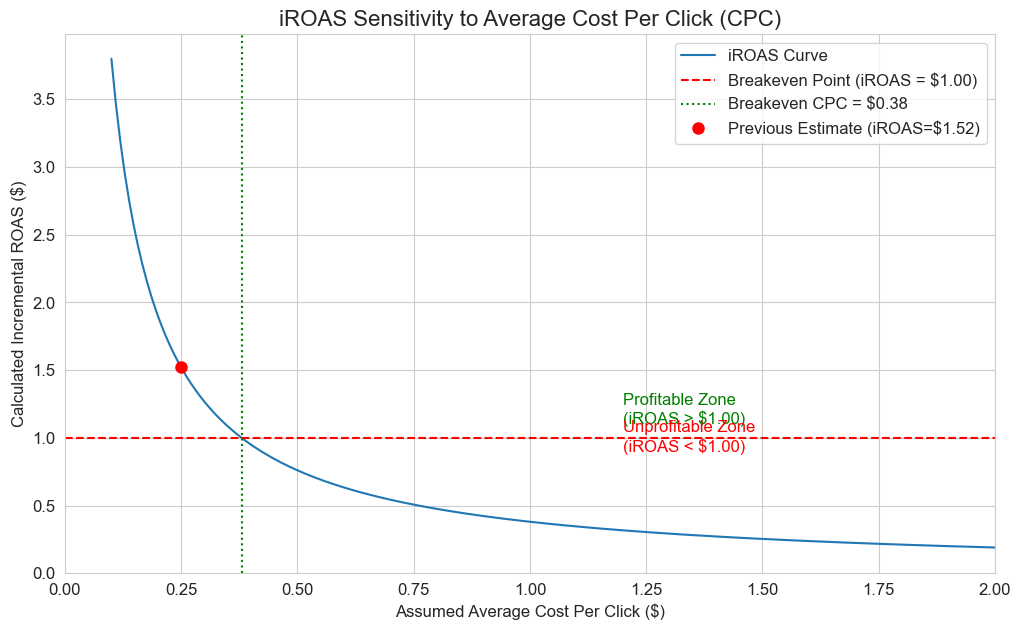

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# --- 1. Define Your Model Input ---

# Your elasticity coefficient from the full-history fixest model
beta_elasticity = 0.6422

# --- 2. Load Your Data to Calculate the Marginal Revenue per Click ---
try:
    display(Markdown("### 5. Sensitivity Analysis: iROAS vs. Cost Per Click (CPC)"))
    
    parquet_filename = 'vendor_panel_full_history_clicks_only.parquet'
    df_full = pd.read_parquet(parquet_filename)

    # Convert columns to standard numeric types
    df_full['revenue_dollars'] = df_full['revenue_dollars'].astype(float)
    df_full['clicks'] = df_full['clicks'].astype(int)

    # Calculate platform-wide totals
    total_revenue = df_full['revenue_dollars'].sum()
    total_clicks = df_full['clicks'].sum()
    
    # Calculate the average revenue generated per click
    avg_revenue_per_click = total_revenue / total_clicks
    
    # This is the key intermediate value: Incremental Revenue from one more click
    marginal_revenue_per_click = beta_elasticity * avg_revenue_per_click

    # --- 3. Generate Data for the Plot ---
    
    # Create a range of plausible CPCs to test, from $0.10 to $2.00
    cpc_range = np.linspace(0.10, 2.00, 200)
    
    # Calculate iROAS for each CPC in the range using the formula
    # iROAS = Marginal Revenue per Click / CPC
    iroas_values = marginal_revenue_per_click / cpc_range

    # --- 4. Create the Plot ---
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    
    # Plot the main iROAS curve
    sns.lineplot(x=cpc_range, y=iroas_values, label='iROAS Curve')
    
    # Add a critical reference line at iROAS = $1.00 (the breakeven point)
    plt.axhline(1.0, color='red', linestyle='--', label='Breakeven Point (iROAS = $1.00)')
    
    # --- Annotate Key Points ---
    # Find the breakeven CPC (where iROAS = 1.0)
    # 1.0 = marginal_revenue_per_click / breakeven_cpc  =>  breakeven_cpc = marginal_revenue_per_click
    breakeven_cpc = marginal_revenue_per_click
    plt.axvline(breakeven_cpc, color='green', linestyle=':', label=f'Breakeven CPC = ${breakeven_cpc:.2f}')
    
    # Annotate the previous single-point estimate
    previous_cpc = 0.25
    previous_iroas = marginal_revenue_per_click / previous_cpc
    plt.plot(previous_cpc, previous_iroas, 'ro', markersize=8, label=f'Previous Estimate (iROAS=${previous_iroas:.2f})')
    
    # --- Final Plot Formatting ---
    plt.title('iROAS Sensitivity to Average Cost Per Click (CPC)', fontsize=16)
    plt.xlabel('Assumed Average Cost Per Click ($)', fontsize=12)
    plt.ylabel('Calculated Incremental ROAS ($)', fontsize=12)
    plt.legend()
    plt.xlim(0, 2.0)
    plt.ylim(0) # Start y-axis at 0
    
    # Add explanatory text on the plot
    plt.text(1.2, 1.1, 'Profitable Zone\n(iROAS > $1.00)', color='green', fontsize=12, ha='left')
    plt.text(1.2, 0.9, 'Unprofitable Zone\n(iROAS < $1.00)', color='red', fontsize=12, ha='left')
    
    plt.show()

except FileNotFoundError:
    print(f"ERROR: Data file '{parquet_filename}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# vendor level effects

In [60]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, Markdown

# --- 1. Set up rpy2 Environment for lme4 ---
# (Assuming setup is complete and successful)
if not rpy2_setup_failed:
    # --- 2. Load and Prepare Data (if not already in memory) ---
    if 'df_analysis' not in locals():
        parquet_filename = 'vendor_panel_full_history_clicks_only.parquet'
        print(f"\n--- Loading panel data from '{parquet_filename}' ---")
        df_analysis = pd.read_parquet(parquet_filename)
        # Convert types immediately after loading
        df_analysis['revenue_dollars'] = df_analysis['revenue_dollars'].astype(float)
        df_analysis['clicks'] = df_analysis['clicks'].astype(int)
        df_analysis['log_revenue_plus_1'] = np.log1p(df_analysis['revenue_dollars'])
        df_analysis['log_clicks_plus_1'] = np.log1p(df_analysis['clicks'])
        print(f"✅ Data loaded and converted successfully.")

    # --- Data Cleaning and Feature Engineering for a Stable Model ---
    vendor_counts = df_analysis['vendor_id'].value_counts()
    vendors_with_enough_data = vendor_counts[vendor_counts > 1].index
    df_clean = df_analysis[df_analysis['vendor_id'].isin(vendors_with_enough_data)].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    # =================================================================================
    # FIX #1: Rescale the continuous predictor (log_clicks_plus_1)
    # This directly addresses the "very large eigenvalue" warning.
    # =================================================================================
    mean_log_clicks = df_clean['log_clicks_plus_1'].mean()
    std_log_clicks = df_clean['log_clicks_plus_1'].std()
    df_clean['log_clicks_scaled'] = (df_clean['log_clicks_plus_1'] - mean_log_clicks) / std_log_clicks
    
    print(f"\n✅ Using a clean subset of {len(df_clean):,} rows for the mixed-effects model.")
    print(f"✅ Scaled 'log_clicks' to have mean=0, std=1 to improve model stability.")

    if not df_clean.empty:
        # --- 3. Run the Improved lme4 Model for Heterogeneity ---
        try:
            display(Markdown("---"))
            display(Markdown("### 3. Improved Heterogeneity Model (`lme4`) on Full History"))
            display(Markdown("Applying best practices: rescaling predictors and using a more robust optimizer to ensure model convergence."))
            
            with localconverter(ro.default_converter + pandas2ri.converter):
                ro.globalenv['df_for_r_clean'] = pandas2ri.py2rpy(df_clean)

            print("\nEstimating Improved Mixed-Effects Model with `lme4`...")
            ro.r("""
            library(lme4)
            
            # =================================================================================
            # FIX #2 & #3: Use a more robust optimizer and simplify the random effects.
            # `(log_clicks_scaled || vendor_id)` fits random intercepts and slopes but assumes
            # they are uncorrelated, which is a simpler, more stable structure.
            # `optimizer="bobyqa"` is a robust choice for complex models.
            # =================================================================================
            lmer_model_stable <- lmer(
              log_revenue_plus_1 ~ log_clicks_scaled + (log_clicks_scaled || vendor_id) + (1 | week),
              data = df_for_r_clean,
              control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5))
            )
            
            # Extract coefficients. Note they are for the SCALED clicks variable now.
            vendor_coefs <- coef(lmer_model_stable)$vendor_id
            beta_v_scaled_regularized <- vendor_coefs[, "log_clicks_scaled"]
            
            # To make the slopes interpretable, we must un-scale them back to the original units.
            # Unscaling formula: beta_original = beta_scaled / std_dev
            beta_v_unscaled <- beta_v_scaled_regularized / sd(df_for_r_clean$log_clicks_plus_1)
            
            beta_v_summary <- summary(beta_v_unscaled)
            """)
            
            # --- Display the results as a clean table ---
            display(Markdown("#### Regularized Distribution of Vendor-Specific Click Elasticities (βv)"))
            print("\n--- Summary Statistics of Regularized Vendor Slopes (βv) from Improved `lme4` Model ---")
            
            beta_v_summary_r = ro.r('beta_v_summary')
            summary_dict = {
                'Min.': [beta_v_summary_r[0]], '1st Qu.': [beta_v_summary_r[1]],
                'Median': [beta_v_summary_r[2]], 'Mean': [beta_v_summary_r[3]],
                '3rd Qu.': [beta_v_summary_r[4]], 'Max.': [beta_v_summary_r[5]]
            }
            summary_df = pd.DataFrame.from_dict(summary_dict, orient='index', columns=['value'])
            show_table(summary_df.reset_index().rename(columns={'index': 'Statistic'}), "Summary of Regularized βv Distribution")
            
            display(Markdown("✅ Heterogeneity analysis completed successfully with a stable model."))

        except Exception as e:
            print(f"\nERROR running the lme4 model in R: {e}")

        print("\n--- Analysis completed ---")


✅ Using a clean subset of 969,558 rows for the mixed-effects model.
✅ Scaled 'log_clicks' to have mean=0, std=1 to improve model stability.


---

### 3. Improved Heterogeneity Model (`lme4`) on Full History

Applying best practices: rescaling predictors and using a more robust optimizer to ensure model convergence.


Estimating Improved Mixed-Effects Model with `lme4`...


#### Regularized Distribution of Vendor-Specific Click Elasticities (βv)


--- Summary Statistics of Regularized Vendor Slopes (βv) from Improved `lme4` Model ---

Summary of Regularized βv Distribution
+-------------+----------+
| Statistic   |    value |
+=============+==========+
| Min.        | 0.194223 |
+-------------+----------+
| 1st Qu.     | 0.748671 |
+-------------+----------+
| Median      | 0.778834 |
+-------------+----------+
| Mean        | 0.772127 |
+-------------+----------+
| 3rd Qu.     | 0.799461 |
+-------------+----------+
| Max.        | 1.26515  |
+-------------+----------+


✅ Heterogeneity analysis completed successfully with a stable model.


--- Analysis completed ---



--- Loading and preparing panel data from 'vendor_panel_full_history_clicks_only.parquet' ---
✅ Data loaded and prepared for 969,558 rows.


### 1. Estimating Regularized Vendor Elasticities (βv)


Estimating Improved Mixed-Effects Model with `lme4`... (This may take several minutes)
✅ Model estimation complete.


### 2. Calculating Vendor-Specific iROAS (iROASv)


Assuming a platform-wide average CPC of $0.20
✅ Vendor-specific iROAS calculated.


### 3. Visualizing the Full Distributions

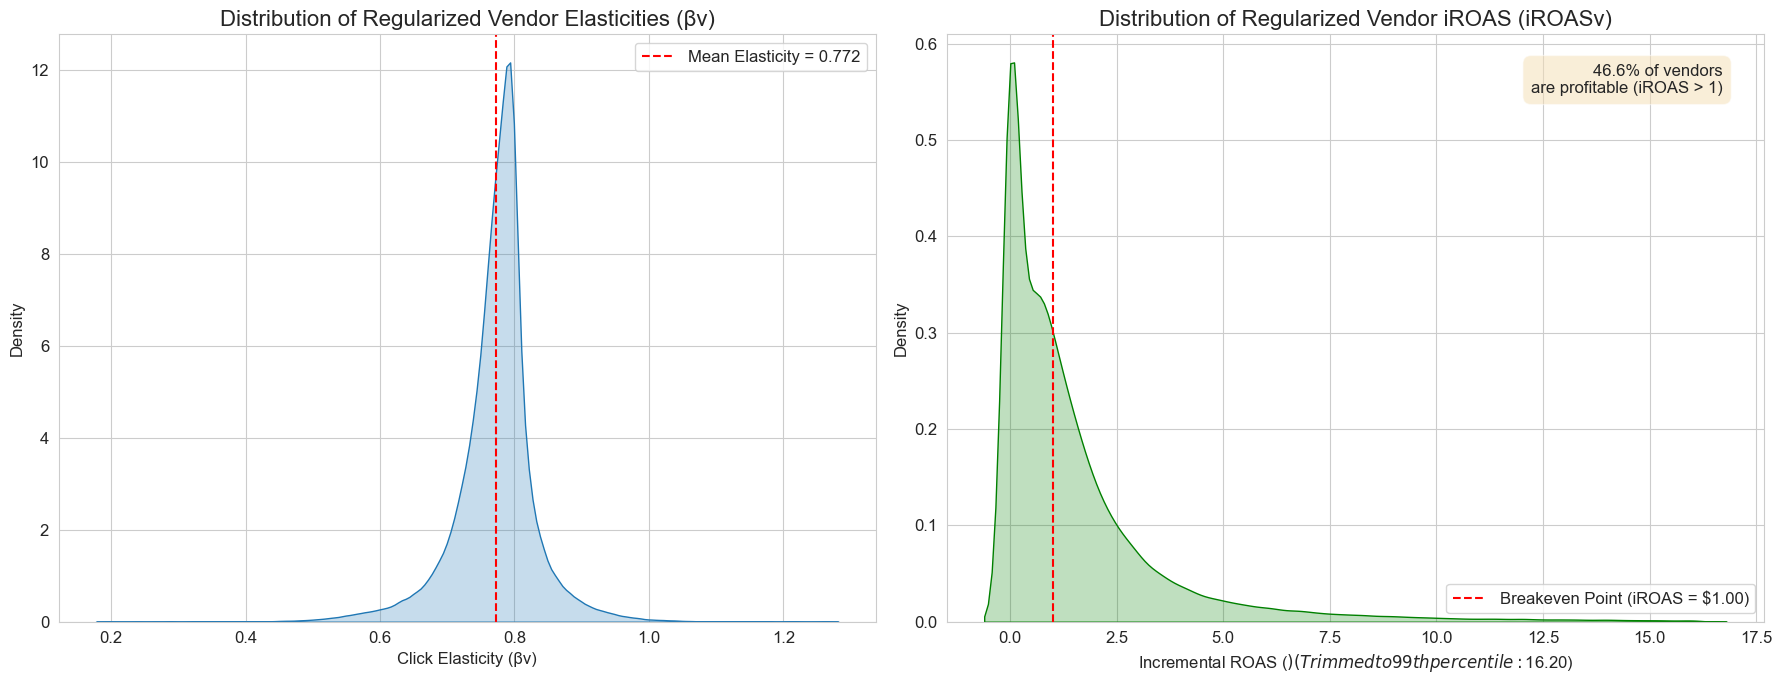


--- Analysis completed ---


In [62]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# --- 1. Set up rpy2 Environment for lme4 ---
# (Assuming setup is complete and successful)
if not rpy2_setup_failed:
    # --- 2. Load and Prepare Data (if not already in memory) ---
    if 'df_analysis' not in locals() or 'log_clicks_scaled' not in df_analysis.columns:
        parquet_filename = 'vendor_panel_full_history_clicks_only.parquet'
        print(f"\n--- Loading and preparing panel data from '{parquet_filename}' ---")
        df_analysis = pd.read_parquet(parquet_filename)
        
        # Convert types and create log variables
        df_analysis['revenue_dollars'] = df_analysis['revenue_dollars'].astype(float)
        df_analysis['clicks'] = df_analysis['clicks'].astype(int)
        df_analysis['log_revenue_plus_1'] = np.log1p(df_analysis['revenue_dollars'])
        df_analysis['log_clicks_plus_1'] = np.log1p(df_analysis['clicks'])

        # Data Cleaning for Mixed-Effects Models
        vendor_counts = df_analysis['vendor_id'].value_counts()
        vendors_with_enough_data = vendor_counts[vendor_counts > 1].index
        df_clean = df_analysis[df_analysis['vendor_id'].isin(vendors_with_enough_data)].copy()
        
        # Rescale the continuous predictor for model stability
        mean_log_clicks = df_clean['log_clicks_plus_1'].mean()
        std_log_clicks = df_clean['log_clicks_plus_1'].std()
        df_clean['log_clicks_scaled'] = (df_clean['log_clicks_plus_1'] - mean_log_clicks) / std_log_clicks
        
        print(f"✅ Data loaded and prepared for {len(df_clean):,} rows.")

    if not df_clean.empty:
        # --- 3. Run the Improved lme4 Model for Heterogeneity ---
        try:
            display(Markdown("### 1. Estimating Regularized Vendor Elasticities (βv)"))
            
            with localconverter(ro.default_converter + pandas2ri.converter):
                ro.globalenv['df_for_r_clean'] = pandas2ri.py2rpy(df_clean)

            print("\nEstimating Improved Mixed-Effects Model with `lme4`... (This may take several minutes)")
            ro.r("""
            library(lme4)
            
            # Fit the stable model with a robust optimizer
            lmer_model_stable <- lmer(
              log_revenue_plus_1 ~ log_clicks_scaled + (log_clicks_scaled || vendor_id) + (1 | week),
              data = df_for_r_clean,
              control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5))
            )
            
            # Extract scaled coefficients
            vendor_coefs <- coef(lmer_model_stable)$vendor_id
            beta_v_scaled_regularized <- vendor_coefs[, "log_clicks_scaled"]
            
            # Un-scale them to get the true, interpretable elasticities
            beta_v_unscaled <- beta_v_scaled_regularized / sd(df_for_r_clean$log_clicks_plus_1)
            
            beta_v_df <- data.frame(
              vendor_id = rownames(vendor_coefs),
              vendor_slope_beta_v = as.numeric(beta_v_unscaled)
            )
            """)
            
            # Convert the final slopes back to a pandas DataFrame
            with localconverter(ro.default_converter + pandas2ri.converter):
                beta_v_df = ro.r('beta_v_df')
            print("✅ Model estimation complete.")

            # --- 4. Calculate Vendor-Specific iROAS ---
            display(Markdown("### 2. Calculating Vendor-Specific iROAS (iROASv)"))

            # Assume a platform-wide average CPC
            assumed_cpc = 0.2
            print(f"\nAssuming a platform-wide average CPC of ${assumed_cpc:.2f}")

            # Calculate each vendor's average revenue per click
            vendor_metrics = df_clean.groupby('vendor_id').agg(
                total_revenue=('revenue_dollars', 'sum'),
                total_clicks=('clicks', 'sum')
            ).reset_index()
            vendor_metrics['avg_rev_per_click'] = vendor_metrics['total_revenue'] / vendor_metrics['total_clicks']
            vendor_metrics = vendor_metrics.replace([np.inf, -np.inf], 0).fillna(0) # Handle division by zero

            # Merge the elasticities (βv) with the business metrics
            df_results = pd.merge(beta_v_df, vendor_metrics, on='vendor_id', how='inner')

            # Calculate iROAS for each vendor
            df_results['iroas_v'] = (df_results['vendor_slope_beta_v'] * df_results['avg_rev_per_click']) / assumed_cpc
            print("✅ Vendor-specific iROAS calculated.")

            # --- 5. Visualize the Full Distributions ---
            display(Markdown("### 3. Visualizing the Full Distributions"))

            # For visualization, it's helpful to trim extreme iROAS outliers
            # to focus on the core distribution.
            lower_bound = df_results['iroas_v'].quantile(0.01)
            upper_bound = df_results['iroas_v'].quantile(0.99)
            df_trimmed = df_results[df_results['iroas_v'].between(lower_bound, upper_bound)]
            
            fig, axes = plt.subplots(1, 2, figsize=(18, 7))

            # Plot 1: Distribution of Vendor Elasticities (βv)
            sns.kdeplot(data=df_results, x='vendor_slope_beta_v', fill=True, ax=axes[0])
            mean_beta = df_results['vendor_slope_beta_v'].mean()
            axes[0].axvline(mean_beta, color='red', linestyle='--', label=f'Mean Elasticity = {mean_beta:.3f}')
            axes[0].set_title('Distribution of Regularized Vendor Elasticities (βv)', fontsize=16)
            axes[0].set_xlabel('Click Elasticity (βv)')
            axes[0].legend()

            # Plot 2: Distribution of Vendor iROAS (iROASv)
            sns.kdeplot(data=df_trimmed, x='iroas_v', fill=True, ax=axes[1], color='green')
            axes[1].axvline(1.0, color='red', linestyle='--', label='Breakeven Point (iROAS = $1.00)')
            profitable_vendors_pct = (df_results['iroas_v'] > 1.0).mean() * 100
            axes[1].set_title('Distribution of Regularized Vendor iROAS (iROASv)', fontsize=16)
            axes[1].set_xlabel(f'Incremental ROAS ($) (Trimmed to 99th percentile: ${upper_bound:.2f})')
            axes[1].legend()
            
            # Add annotation
            axes[1].text(0.95, 0.95, f'{profitable_vendors_pct:.1f}% of vendors\nare profitable (iROAS > 1)', 
                         transform=axes[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right',
                         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\nERROR running the analysis pipeline in R: {e}")

        print("\n--- Analysis completed ---")

# hill curves

In [65]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, Markdown

# --- 1. Set up rpy2 Environment and Install brms ---
# (Assuming setup is complete)
if not rpy2_setup_failed:
    # --- 2. Load and Prepare Data for Nonlinear Model ---
    if 'df_analysis' not in locals():
        parquet_filename = 'vendor_panel_full_history_clicks_only.parquet'
        print(f"\n--- Loading panel data from '{parquet_filename}' ---")
        df_analysis = pd.read_parquet(parquet_filename)
        # IMPORTANT: For nonlinear models, we work with the original dollar/click counts, not logs.
        df_analysis['revenue_dollars'] = df_analysis['revenue_dollars'].astype(float)
        df_analysis['clicks'] = df_analysis['clicks'].astype(int)
        print(f"✅ Data loaded successfully.")

    # --- Prepare a sample for the Bayesian model ---
    vendor_counts = df_analysis['vendor_id'].value_counts()
    vendors_with_enough_data = vendor_counts[vendor_counts > 4].index # Need more data for nonlinear
    df_clean = df_analysis[df_analysis['vendor_id'].isin(vendors_with_enough_data)]
    
    all_vendors = df_clean['vendor_id'].unique()
    sample_vendors = np.random.choice(all_vendors, size=min(200, len(all_vendors)), replace=False) # Smaller sample
    df_bayesian_sample = df_clean[df_clean['vendor_id'].isin(sample_vendors)]
    
    print(f"\n✅ Using a clean sample of {len(df_bayesian_sample):,} rows from {len(sample_vendors)} vendors for the Bayesian S-curve model.")

    if not df_bayesian_sample.empty:
        # --- 3. Run the Bayesian Hierarchical S-Curve Model ---
        try:
            display(Markdown("### 4. Advanced Model: Hierarchical S-Curves with `brms`"))
            display(Markdown("This model estimates a unique, regularized S-curve of diminishing returns for each vendor."))
            
            with localconverter(ro.default_converter + pandas2ri.converter):
                ro.globalenv['df_bayesian_sample_r'] = pandas2ri.py2rpy(df_bayesian_sample)

            print("\nEstimating Bayesian S-Curve Model. This is computationally intensive and will take significant time...")
            ro.r("""
            library(brms)
            
            # Define the nonlinear Hill function and hierarchical priors
            hill_formula <- bf(
                revenue_dollars ~ max * clicks^slope / (ec50^slope + clicks^slope),
                max ~ 1 + (1 | vendor_id),
                slope ~ 1 + (1 | vendor_id),
                ec50 ~ 1 + (1 | vendor_id),
                nl = TRUE
            )
            
            # Priors are ESSENTIAL for nonlinear models to converge.
            # These are weakly informative priors based on the data scale.
            hill_priors <- c(
                prior(normal(100, 50), nlpar = "max", lb=0),
                prior(normal(1.5, 0.5), nlpar = "slope", lb=0),
                prior(normal(200, 100), nlpar = "ec50", lb=0),
                prior(exponential(0.1), class = "sd", nlpar = "max"),
                prior(exponential(1), class = "sd", nlpar = "slope"),
                prior(exponential(0.01), class = "sd", nlpar = "ec50")
            )
            
            s_curve_model <- brm(
              formula = hill_formula,
              data = df_bayesian_sample_r,
              family = gaussian(link = "log"), # Use log link as revenue > 0
              prior = hill_priors,
              chains = 2, iter = 1500, warmup = 750, cores = 2, # Reduced for speed
              control = list(adapt_delta = 0.95),
              seed = 42,
              silent = 2, refresh = 0
            )
            
            # Extract the vendor-specific parameters
            vendor_params <- coef(s_curve_model, robust=TRUE)$vendor_id
            
            # Rename columns for clarity before sending to Python
            colnames(vendor_params) <- c("max_est", "max_se", "max_lower", "max_upper",
                                         "slope_est", "slope_se", "slope_lower", "slope_upper",
                                         "ec50_est", "ec50_se", "ec50_lower", "ec50_upper")
            
            vendor_params_df <- as.data.frame(vendor_params)
            vendor_params_df$vendor_id <- rownames(vendor_params)
            """)
            
            # --- Convert results back to Python and Display ---
            with localconverter(ro.default_converter + pandas2ri.converter):
                vendor_params_df = ro.r('vendor_params_df')
            
            display(Markdown("#### Distribution of Vendor S-Curve Parameters"))
            show_table(vendor_params_df[['vendor_id', 'max_est', 'slope_est', 'ec50_est']].describe(),
                       "Summary Statistics of Vendor S-Curve Parameters")

        except Exception as e:
            print(f"\nERROR running the Bayesian S-curve model in R: {e}")


✅ Using a clean sample of 2,696 rows from 200 vendors for the Bayesian S-curve model.


### 4. Advanced Model: Hierarchical S-Curves with `brms`

This model estimates a unique, regularized S-curve of diminishing returns for each vendor.


Estimating Bayesian S-Curve Model. This is computationally intensive and will take significant time...


R callback write-console: Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: There were 788 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them. 
  
R callback write-console: 2: Examine the pairs() plot to diagnose sampling problems
 
  
R callback write-console: 3: The largest R-hat is 2.15, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat 
  
R callback write-console: 4: Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess 
  
R callback write-console: 5: Tail Effective Samples Size 


ERROR running the Bayesian S-curve model in R: Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent



In [67]:
# (Run this cell after the brms model finishes)
if 'vendor_params_df' in locals():
    # --- Calculating and Plotting Variable iROAS ---
    display(Markdown("#### iROAS Calculation from S-Curves"))
    
    # Pick one sample vendor from the results
    sample_vendor = vendor_params_df.iloc[0]
    
    # Get their estimated S-curve parameters
    v_max = sample_vendor['max_est']
    v_slope = sample_vendor['slope_est']
    v_ec50 = sample_vendor['ec50_est']
    
    # Assume a CPC
    assumed_cpc = 0.75
    
    def calculate_iroas(clicks, p_max, p_slope, p_ec50, cpc):
        # Derivative of the Hill function
        numerator = p_max * p_slope * (p_ec50**p_slope) * (clicks**(p_slope-1))
        denominator = ((p_ec50**p_slope) + (clicks**p_slope))**2
        marginal_revenue_per_click = numerator / denominator
        return marginal_revenue_per_click / cpc

    # Calculate iROAS at different click levels
    clicks_low = 50
    clicks_mid = v_ec50 # At the half-saturation point
    clicks_high = v_ec50 * 3 # In the saturation zone
    
    iroas_low = calculate_iroas(clicks_low, v_max, v_slope, v_ec50, assumed_cpc)
    iroas_mid = calculate_iroas(clicks_mid, v_max, v_slope, v_ec50, assumed_cpc)
    iroas_high = calculate_iroas(clicks_high, v_max, v_slope, v_ec50, assumed_cpc)
    
    iroas_table = {
        "Click Level": [f"Low ({clicks_low} clicks)", f"Mid ({int(clicks_mid)} clicks)", f"High ({int(clicks_high)} clicks)"],
        "Calculated iROAS": [f"${iroas_low:.2f}", f"${iroas_mid:.2f}", f"${iroas_high:.2f}"]
    }
    show_table(pd.DataFrame(iroas_table), f"Variable iROAS for Vendor: {sample_vendor['vendor_id']}")
    
    print("\nInterpretation: As clicks (and spend) increase, the incremental ROAS decreases,")
    print("reflecting diminishing returns.")